In [59]:
# Importing standard Qiskit libraries and configuring account
import qiskit as qk
from qiskit import QuantumCircuit, Aer, IBMQ
from qiskit import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import plot_histogram
from math import pi
from qiskit.extensions import UnitaryGate

from PIL import Image
import numpy as np
import math

In [237]:
n = 6

qcA = QuantumCircuit(n+3)
qcA.h(i for i in range(n))

def encode(qc, r, g, b):
    qs = [i for i in range(n)]
    qcA.append(
        UnitaryGate([
            [np.cos(r), -np.sin(r)],
            [np.sin(r), np.cos(r)]
        ], 'Ry('+str(round(r, 2))+')').control(n), 
        qs + [n]
    )
    qcA.append(
        UnitaryGate([
            [np.cos(g), -np.sin(g)],
            [np.sin(g), np.cos(g)]
        ], 'Ry('+str(round(g, 2))+')').control(n), 
        qs + [n + 1]
    )
    qcA.append(
        UnitaryGate([
            [np.cos(b), -np.sin(b)],
            [np.sin(b), np.cos(b)]
        ], 'Ry('+str(round(b, 2))+')').control(n), 
        qs + [n + 2]
    )
    
def rgbToRadian(x):
    return (x/255)*(pi/2)

r = np.concatenate((np.linspace(255, 0, 2**(n-1)), np.zeros(2**(n-1))))
g = np.concatenate((np.zeros(2**(n-1)), np.linspace(0, 255, 2**(n-1))))
b = np.concatenate((np.linspace(0, 255, 2**(n-1)), np.linspace(255, 0, 2**(n-1))))
r = rgbToRadian(r)
g = rgbToRadian(g)
b = rgbToRadian(b)

for i in range(2**n):
    qcA.barrier()
    if i != 0:
        for j, x in enumerate(bin(i ^ (i-1))[2:].zfill(n)):
            if x == '1':
                qcA.x(n - j - 1)
    encode(qcA, r[i], g[i], b[i])

qcA.measure_all()

qcA.draw()

┌───┐ ░                                    ░ ┌───┐            »
   q_0: ┤ H ├─░──────■───────────■──────────■──────░─┤ X ├─────■──────»
        ├───┤ ░      │           │          │      ░ └───┘     │      »
   q_1: ┤ H ├─░──────■───────────■──────────■──────░───────────■──────»
        ├───┤ ░      │           │          │      ░           │      »
   q_2: ┤ H ├─░──────■───────────■──────────■──────░───────────■──────»
        ├───┤ ░      │           │          │      ░           │      »
   q_3: ┤ H ├─░──────■───────────■──────────■──────░───────────■──────»
        ├───┤ ░      │           │          │      ░           │      »
   q_4: ┤ H ├─░──────■───────────■──────────■──────░───────────■──────»
        ├───┤ ░      │           │          │      ░           │      »
   q_5: ┤ H ├─░──────■───────────■──────────■──────░───────────■──────»
        └───┘ ░ ┌────┴─────┐     │          │      ░      ┌────┴─────┐»
   q_6: ──────░─┤ Ry(1.57) ├─────┼──────────┼──────░──────┤ Ry(1.52) ├»
              ░ └──────────┘┌────┴────┐     │      ░      └──────────┘»
   q_7: ──────░─────────────┤ Ry(0.0) ├─────┼──────░──────────────────»
              ░             └─────────┘┌────┴────┐ ░                  »
   q_8: ──────░────────────────────────┤ Ry(0.0) ├─░──────────────────»
              ░                        └─────────┘ ░                  »
meas: 9/══════════════════════════════════════════════════════════════»
                                                                      »
«                                ░ ┌───┐                                   ░ »
«   q_0: ─────■──────────■───────░─┤ X ├─────■───────────■──────────■──────░─»
«             │          │       ░ ├───┤     │           │          │      ░ »
«   q_1: ─────■──────────■───────░─┤ X ├─────■───────────■──────────■──────░─»
«             │          │       ░ └───┘     │           │          │      ░ »
«   q_2: ─────■──────────■───────░───────────■───────────■──────────■──────░─»
«             │          │       ░           │           │          │      ░ »
«   q_3: ─────■──────────■───────░───────────■───────────■──────────■──────░─»
«             │          │       ░           │           │          │      ░ »
«   q_4: ─────■──────────■───────░───────────■───────────■──────────■──────░─»
«             │          │       ░           │           │          │      ░ »
«   q_5: ─────■──────────■───────░───────────■───────────■──────────■──────░─»
«             │          │       ░      ┌────┴─────┐     │          │      ░ »
«   q_6: ─────┼──────────┼───────░──────┤ Ry(1.47) ├─────┼──────────┼──────░─»
«        ┌────┴────┐     │       ░      └──────────┘┌────┴────┐     │      ░ »
«   q_7: ┤ Ry(0.0) ├─────┼───────░──────────────────┤ Ry(0.0) ├─────┼──────░─»
«        └─────────┘┌────┴─────┐ ░                  └─────────┘┌────┴────┐ ░ »
«   q_8: ───────────┤ Ry(0.05) ├─░─────────────────────────────┤ Ry(0.1) ├─░─»
«                   └──────────┘ ░                             └─────────┘ ░ »
«meas: 9/════════════════════════════════════════════════════════════════════»
«                                                                            »
«        ┌───┐                                    ░ ┌───┐            »
«   q_0: ┤ X ├─────■───────────■──────────■───────░─┤ X ├─────■──────»
«        └───┘     │           │          │       ░ ├───┤     │      »
«   q_1: ──────────■───────────■──────────■───────░─┤ X ├─────■──────»
«                  │           │          │       ░ ├───┤     │      »
«   q_2: ──────────■───────────■──────────■───────░─┤ X ├─────■──────»
«                  │           │          │       ░ └───┘     │      »
«   q_3: ──────────■───────────■──────────■───────░───────────■──────»
«                  │           │          │       ░           │      »
«   q_4: ──────────■───────────■──────────■───────░───────────■──────»
«                  │           │          │       ░           │      »
«   q_5: ──────────■───────────■──────────■───────░─────

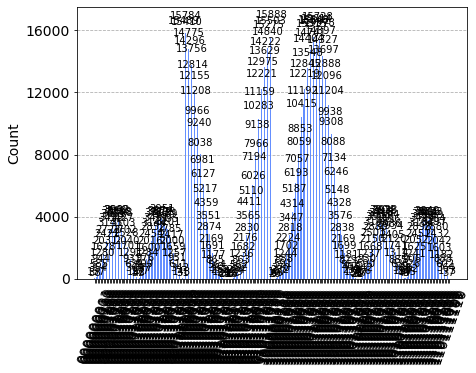

In [240]:
aer_sim = Aer.get_backend('aer_simulator')
t_qcA = transpile(qcA, aer_sim)
result = aer_sim.run(t_qcA, shots=1000000).result()
counts = result.get_counts(qcA)
plot_histogram(counts, sort='asc')

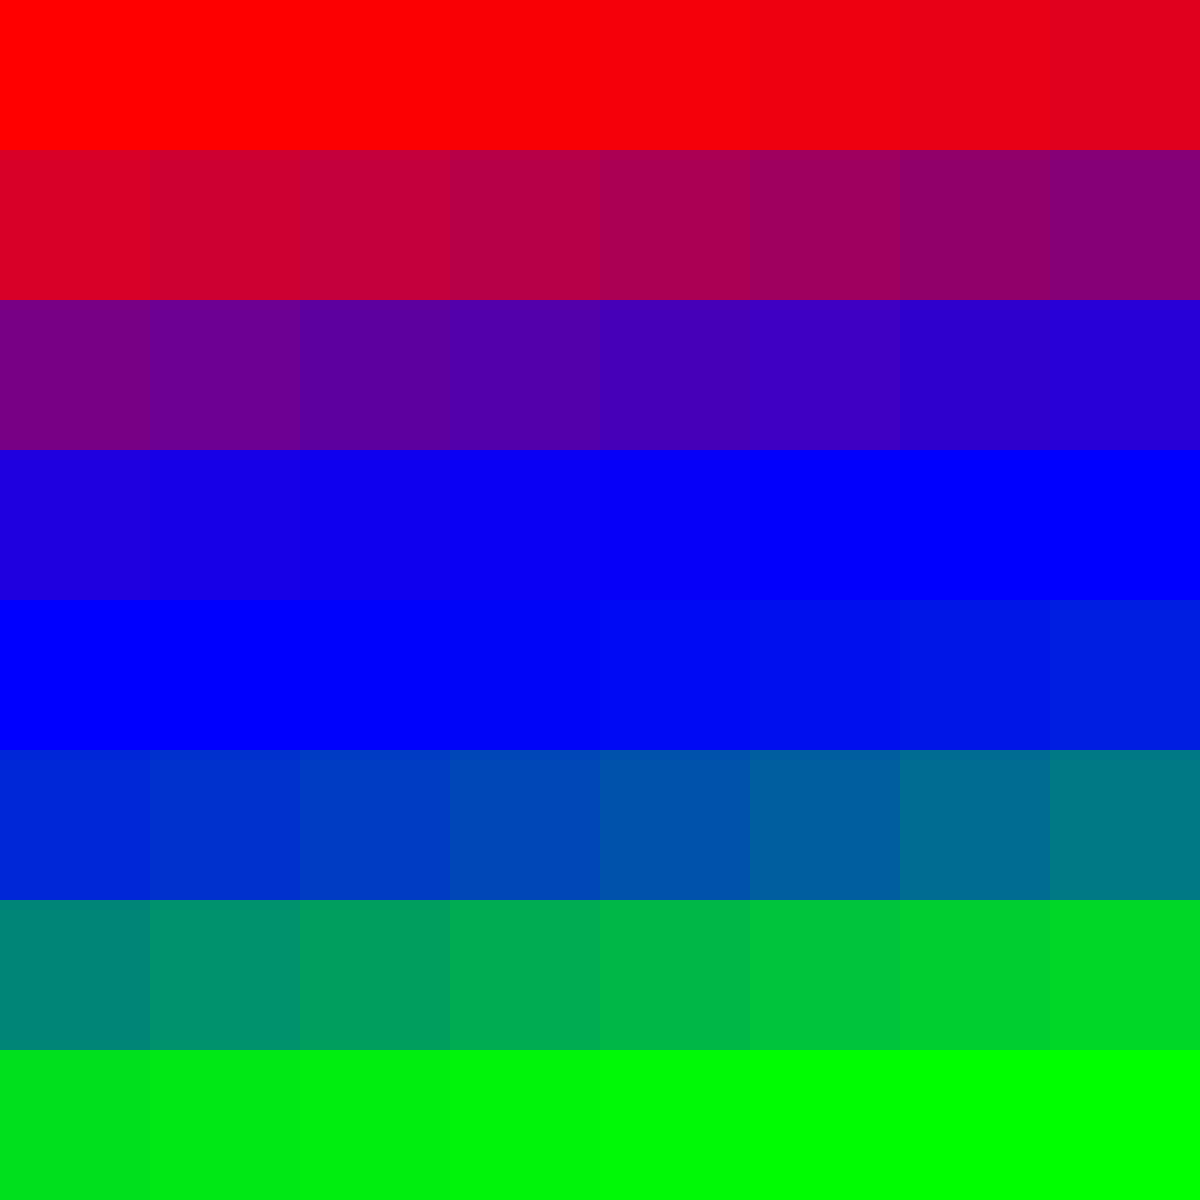

In [242]:
red = np.zeros(2**n)
green = np.zeros(2**n)
blue = np.zeros(2**n)
total = np.zeros(2**n)
for state in counts:
    i = int(state[-n:], 2)
    total[i] += counts[state]
    if state[2] == '1':
        red[i] += counts[state]
    if state[1] == '1':
        green[i] += counts[state]
    if state[0] == '1':
        blue[i] += counts[state]
        
w = 2**math.floor(n/2)
h = 2**math.ceil(n/2)
img = Image.new(mode='RGB', size=(w, h))
for i in range(2**n):
    red[i] = ((red[i] / total[i]) * 255) if total[i] != 0 else 0
    green[i] = ((green[i] / total[i]) * 255) if total[i] != 0 else 0
    blue[i] = ((blue[i] / total[i]) * 255) if total[i] > 0 else 0
    img.putpixel((i%w, int(i/w)), (int(red[i]), int(green[i]), int(blue[i])))
img = img.resize((w*150,h*150), Image.NEAREST)
display(img)